This is Library

In [1]:

import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\syukr\anaconda3\envs\food_cnn_py313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
ran = np.random.randint(0, 10, size=(5,))
print("Random integers between 0 and 10:", ran)

Random integers between 0 and 10: [8 8 8 7 2]


Train data

In [ ]:

# ========================================
# IMPROVED TRAINING WITH TRANSFER LEARNING
# ========================================

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 5
train_dir = "../dataset/train"

# Enhanced Data Augmentation for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.2
)

print("Loading training data...")
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Loading validation data...")
validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\n✅ Training samples: {train_data.samples}")
print(f"✅ Validation samples: {validation_data.samples}")
print(f"✅ Classes: {list(train_data.class_indices.keys())}")

# Calculate class weights to handle imbalance (cake has only 60 images)
from sklearn.utils.class_weight import compute_class_weight

class_indices = train_data.class_indices
class_names = list(class_indices.keys())
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n📊 Class weights: {class_weight_dict}")

# ==============================================
# TRANSFER LEARNING MODEL (MobileNetV2)
# ==============================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Create model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📋 Model Summary:")
model.summary()

# ==============================================
# TRAINING CALLBACKS
# ==============================================
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '../best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# ==============================================
# TRAIN MODEL
# ==============================================
print("\n🚀 Starting training with class weights...\n")
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# ==============================================
# SAVE FINAL MODEL
# ==============================================
model.save("../food_cnn_model.keras")
print("\n✅ Model training complete and saved to food_cnn_model.keras!")

# ==============================================
# PLOT TRAINING HISTORY
# ==============================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Train Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Val Loss: {history.history['val_loss'][-1]:.4f}")


Found 792 images belonging to 5 classes.
Found 197 images belonging to 5 classes.


c:\Users\syukr\anaconda3\envs\food_cnn_py313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2323 - loss: 1.6908 - val_accuracy: 0.3909 - val_loss: 1.5124
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3561 - loss: 1.4930 - val_accuracy: 0.3959 - val_loss: 1.4262
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3927 - loss: 1.4636 - val_accuracy: 0.4822 - val_loss: 1.3636
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4356 - loss: 1.3595 - val_accuracy: 0.4619 - val_loss: 1.3257
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4444 - loss: 1.2894 - val_accuracy: 0.4924 - val_loss: 1.2460
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4861 - loss: 1.2412 - val_accuracy: 0.4975 - val_loss: 1.2387
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4886 - loss: 1.2045 - val_accuracy: 0.5228 - val_loss: 1.2601
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4672 - loss: 1.2552 - val_accuracy: 0.4467 - val_loss:

In [12]:
# LOAD MODEL
from tensorflow.keras.models import load_model

model = load_model("food_cnn_model.keras")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# ==============================================
# FINE-TUNING: UNFREEZE TOP LAYERS
# ==============================================
print("\n🔄 Starting fine-tuning phase...\n")

# Unfreeze top layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keep first 30 layers frozen
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for more epochs
fine_tune_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '../best_model_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-8,
        verbose=1
    )
]

history_ft = model.fit(
    train_data,
    epochs=30,
    validation_data=validation_data,
    class_weight=class_weight_dict,
    callbacks=fine_tune_callbacks,
    verbose=1
)

# Save fine-tuned model
model.save("../food_cnn_model.keras")
print("\n✅ Fine-tuning complete! Model saved.")

print(f"\nFinal Val Accuracy after fine-tuning: {history_ft.history['val_accuracy'][-1]:.4f}")


Found 989 images belonging to 5 classes.
📊 Found 989 images in 5 classes
📁 Classes: ['Donut', 'Sandwich', 'hot_dog', 'pizza', 'sushi']

🔮 Making predictions...
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 948ms/step

📈 Classification Report:

              precision    recall  f1-score   support

       Donut       0.79      0.78      0.78       200
    Sandwich       0.76      0.62      0.68       200
     hot_dog       0.68      0.66      0.67       200
       pizza       0.67      0.89      0.76       190
       sushi       0.80      0.72      0.76       199

    accuracy                           0.73       989
   macro avg       0.74      0.73      0.73       989
weighted avg       0.74      0.73      0.73       989



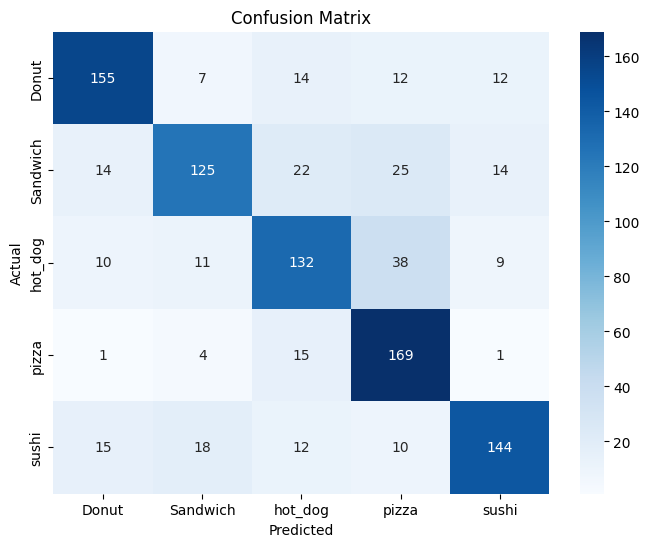

In [13]:
# TEST DATA - Using training data for evaluation since test directory is empty

train_dir = "../dataset/train"

# Create a test generator from training data (no augmentation, no validation split)
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Check if we have data
print(f"📊 Found {test_data.samples} images in {len(test_data.class_indices)} classes")
print(f"📁 Classes: {list(test_data.class_indices.keys())}")

if test_data.samples == 0:
    print("\n⚠️ ERROR: No images found in dataset!")
    print(f"Directory checked: {os.path.abspath(train_dir)}")
    print("\nPlease verify:")
    print("1. Images exist in subdirectories (Donut/, hot_dog/, pizza/, Sandwich/, sushi/)")
    print("2. Images have valid extensions (.jpg, .jpeg, .png, .bmp, .gif)")
    print("3. Path is correct relative to notebook location")
else:
    # -----------------------------
    # PREDICTION
    # -----------------------------
    print("\n🔮 Making predictions...")
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_data.classes

    # -----------------------------
    # CLASS NAMES
    # -----------------------------
    class_names = list(test_data.class_indices.keys())

    # -----------------------------
    # METRICS
    # -----------------------------
    print("\n📈 Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # -----------------------------
    # CONFUSION MATRIX
    # -----------------------------
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
